# GAN for image generation: Monet-style pictures

The aim of the projest is to generate images of size 256x256 in 3 channels that look like Monet's paintings.<br>
Some normal photos and Monet's pictures are provided for input. These will be used fr training, with the final outcome being saved as the output in a zipfile.<br>

Adversarial networks are going to be used for this project part of a Kaggle competition. <br>


The main structure of such networks is the following:
One Generator model is confronted to a Discriminator model, by trying to trick it. <br>
The generator is fed real images to train, and tries to create new ones using the same logic. <br>
The discriminator one has set a vector of 1s for a real image and 0s for a fake one. Once an image is processed, it is expected to output a probability vector for the input image. The cycle is repeated for each of the images, and for several epochs to improve the results.<br>
A loss function is defined both for the discrimnator and the generator. For the discriminator it will be based on the difference between the ouptput and a vector of 1s. I.e, it measure "how fake" the generated image is.
For the generator the loss function will be obtained according to how well it tricked the discriminator.<br>

To stablish a baseline, a light adaptation from the model in the KERAS CycleGAN tutorial was used, then further improvement is done based on the work in a Cycle-GAN model from one fellow kaggler, this second model is based on the [Keras](https://keras.io/examples/generative/cyclegan/) CycleGAN documentation pages. The first submission was created from this model.

## Loading Libraries and Data

This project will use Keras in a GPU, (or TPU if available).

It is worth noting that depending on the tensorflow and tensorflow_addons versions the code may fail. (It works in kaggle plattform but not in coab, for instance (unless a virtual environment is run with the corresponding versions)

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from tensorflow.keras.utils import plot_model
# from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)
print(tfa.__version__)

Number of replicas: 1
2.2.0
0.10.0


# Load in the data

The data for this project has 2 types with 2 classes each. 
1. tfrec (TensorFlowRECord) fies that are formatted to be read by tensorflow. Each of them include the data from a batch of photos included in the jpg images.
2. jpeg RGB images of 256x256 pixels.

Both types include normal photos and Monet's pictures.

The jpeg images have to be loaded to tensorflow first, so their formatting will match the ones for the tfrec files.

The data includes:
* 5 tfrec files for Monet pictures (each loading 60 images)
* 20 tfrec files for Photos (loading about 350-355 images each).
* 300 jpeg Monet pictures.
* 7038 jpeg Photos.

In [2]:
GCS_PATH = "/kaggle/input/gan-getting-started/"


In [3]:
MONET_FILENAMES = tf.io.gfile.glob(str('/kaggle/input/monet-gan-getting-started/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str('/kaggle/input/monet-gan-getting-started/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


The following script decodes the TF records to obtain a 256x256 RGB image for each picture included in the corresponding batch.

For normalization, images are scaled to [-1, 1] range. TFRecord also include image ids and labels. For this model, only the image itself will be loaded.

In [4]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

The data from the TFrec files is loaded. 
A dataloader is used for improving runtime. 


In [5]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

The images are loaded separately for ease of implementation of the code.

In [6]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

In [7]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

Here we show one example of each type of image obtained from the TFrec files.

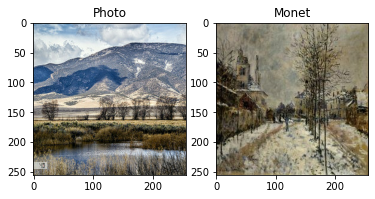

In [8]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

## Creating the model
The CycleGAN architecture is based in the following logic:
We need to adversary models: The generator and the discriminator.

From a picture it generates a new one by using a sequence of convolutional layers decreasing the dimensions, followed by a sequence of transposed convolutional ones to regenerate an image with the same dimensions as the original one. <br>

For a Monet picture, under "perfect" training this algorithm is expected to return the original one. <br>
For a normal photo, this algorithm generates a fake Monet effect into it.<br>

The discriminator model, should output a measure of the probability of a picture being a real one. This model will use a simple convolutional network (might be followed by dense layers). <br>
For each datapoint and for each epoch, the main algorithm will alternate the generator and discriminator models. The loss for the final algorithm will be a combination of the losses of the generator, the discriminator and a final loss function computer after each cycle iteration.


### Build the generator

To create our model, the following logic is applied:

The `downsample`, as the name suggests, reduces the 2D dimensions, the width and height, of the image by the stride, hence reducing the weight and height of the picture in each step.

`Upsample` does the opposite of downsample and increases the dimensions of the of the image. `Conv2DTranspose` does basically the opposite of a `Conv2D` layer.

Within each layer, normalization and a ReLU are also performed.

The main hyperparameter to test here is the stride, which will be the factor at which each dimension of the image is reduced. This has been set to 2 to avoid losing data. 

Other hyperparameters that were tested are the size of the patches for convolution. The results are shown for a convolution patch of size 3x3.

In [9]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

In [10]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

The generator first downsamples the input image and then upsample but also keep long skip connections (that relate the corresponding convolution and transposed convolution layers). To do this, the model is setup with some skip connections. 

In [11]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 3, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 3), # (bs, 64, 64, 128)
        downsample(256, 3), # (bs, 32, 32, 256)
        downsample(512, 3), # (bs, 16, 16, 512)
        downsample(512, 3), # (bs, 8, 8, 512)
        downsample(512, 3), # (bs, 4, 4, 512)
        downsample(512, 3), # (bs, 2, 2, 512)
        downsample(512, 3), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 3, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 3, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 3, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 3), # (bs, 16, 16, 1024)
        upsample(256, 3), # (bs, 32, 32, 512)
        upsample(128, 3), # (bs, 64, 64, 256)
        upsample(64, 3), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 3,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

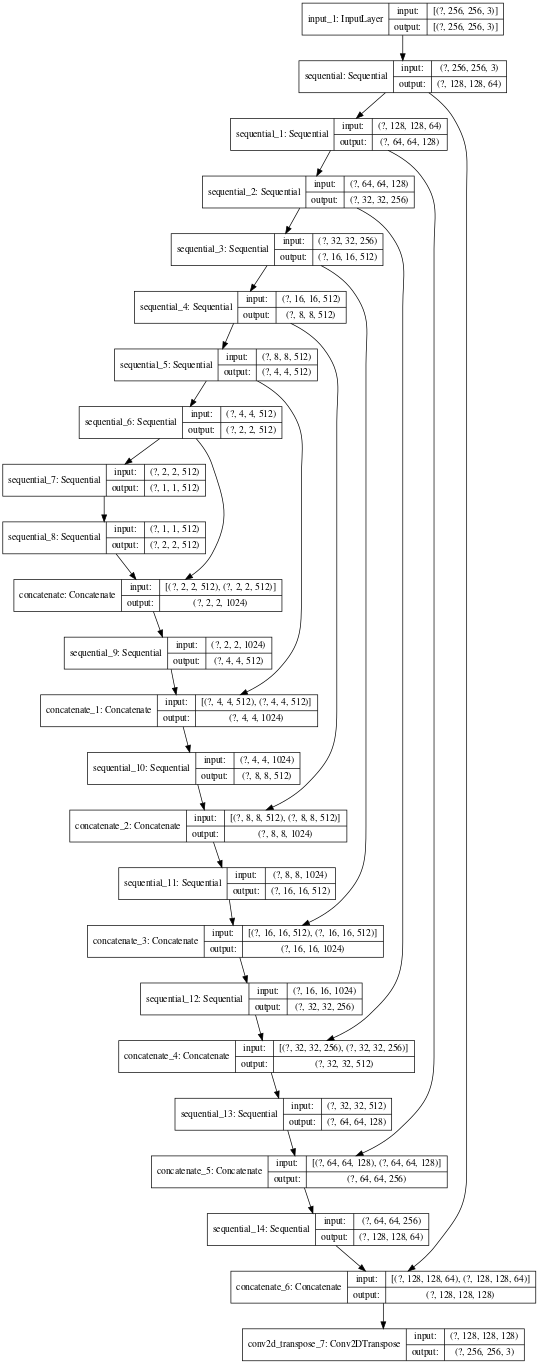

In [12]:
plot_model(Generator(), show_layer_names=True, show_shapes=True, dpi=50)

### Build the discriminator

The discriminator takes in the input image and classifies it as real or fake (generated). In order to being able to keep more features. <br>
Instead of a single output (probability of a photo being real), this algorithm will output a smaller gray-scale picture. where a totally black (1s array) image would be the way to code a real image, and a totally white (0s array) image would code a fake image. 

Convolutional layers like in the generator model are used in the beginning. With the difference that the final layer outputs only one channel (a grayscale normalized image).


The Architecture can be modified by adding or reducing layers.

In [13]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 3, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 3)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 3)(down2) # (bs, 32, 32, 256)
    down4 = downsample(512, 3)(down3) # (bs, 16, 16, 512)


    zero_pad1 = layers.ZeroPadding2D()(down4) # (bs, 18, 18, 256)
    conv = layers.Conv2D(512, 3, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs,15, 15, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 15, 15, 512)

    last = layers.Conv2D(1, 3, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

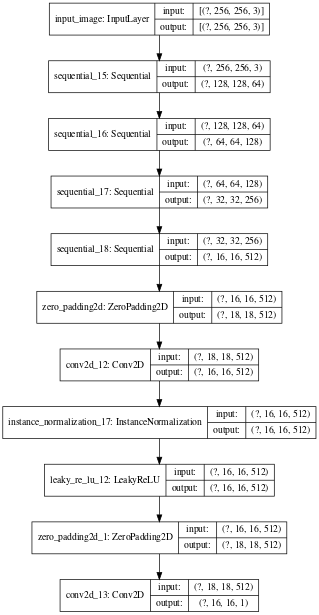

In [14]:
plot_model(Discriminator(), show_layer_names=True, show_shapes=True, dpi=50)

* Remark The strategy.scope() part in the code is used so that the computer will use the apropriate processor (in particular if TPU is available, it will use it, improving runtime).

In [15]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

The generators and discriminators are created for both types of images. If the data were available for a better performance the data from each class would be paired so that pictures match comparable ones. Say a sea landscape photo would be more comparable to a sea landscape Monet picture than to another type of picture.
(This might be done as a preprocessing in a further version, for example). Perhaps the labels in the tfrecords files contain already this type of info ???


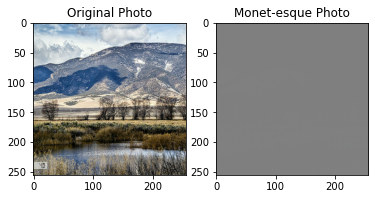

In [16]:
plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

to_monet = monet_generator(example_photo)
plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

### Build the CycleGAN model

The model will be a subclass of `tf.keras.Model`, this way we can run `fit()` to train our model. During the training step, the model transforms a photo to a Monet painting and then back to a photo. A similar action is performed in the Monet's paintings images.<br> 
The difference between the original image and the twice-transformed image will be measured by the cycle-consistency loss. 
We aim the original image and the twice-transformed image to be similar to one another.<br>

In principle, the generators for each of the classes should keep the images in the correspoding class unchanged. This is if M is a Monet picture, then M should equal monet_generator(M), similarly P and photo_generator(P) should a priori be the same.

This means that in our model we have 6 different losses to be measured:
The first four relate the performance of the generators
1. P vs photo_generator(monet_generator(P)) for a photo P
2. M vs monet_generator(photo_generator(M)) for a Monet picture M
3. P vs photo_generator(P)
4. M vs monet_generator (M)
The last two will measure the discriminator performance:   
5. monet_generator(P) and M vs Monet indicators.
6. photo_generator(M) and P vs Photo indicators.

The loss for the whole cycle will be defined as a combination of these 6 losses and will be used as the loss to be minimized.

More details on this will be explained in the construction of each loss function




In [17]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

#### Define loss functions

Remember that the discriminator model creates a one-channel image. In other words, simply a matrix whose entries are between 0 and 1.
Real images are compared to a matrix of 1s and fake images to a matrix of 0s. The perfect discriminator would output all 1s for real images and all 0s for fake images. The discriminator loss outputs the average of the real and generated loss. Since each entry is a probability measure, cross entropy is chosen as the loss function for each type of images.

In [18]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

A perfect generator would fool the discriminator so that it would obtain all 1s outputs after passing the discrimination algorithm. This means that the loss for the generator itself will be based on the difference between an all 1s matrix and its output on the discriminator model.

In [19]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

Cycle consistency loss will measure the difference between the original images and the twice transformed ones. We expect them to be similar to the original picture.

In [20]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

We also want that original phtos and Monet painting  remain unchanged by their respective generators. This means that its loss is based on the difference between both images (in each channel).


In [21]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

## Train the CycleGAN

Since `tf.keras.Model` was used to build the CycleGAN, the `fit` modulewill be used to train the model.
For now, no callbacks are adeed for now, some other might be included later (such as showing one of the generated images or having early stop or changing learning rate)

In [22]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [23]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )
    

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

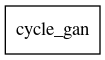

In [24]:
plot_model(cycle_gan_model)

In [25]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=35
)

Epoch 1/35
300/300 [==============================] - 56s 186ms/step - monet_gen_loss: 6.0421 - photo_gen_loss: 6.1856 - monet_disc_loss: 0.5730 - photo_disc_loss: 0.5568
Epoch 2/35
300/300 [==============================] - 56s 186ms/step - monet_gen_loss: 4.0843 - photo_gen_loss: 4.1798 - monet_disc_loss: 0.6605 - photo_disc_loss: 0.6326
Epoch 3/35
300/300 [==============================] - 56s 185ms/step - monet_gen_loss: 3.5412 - photo_gen_loss: 3.6811 - monet_disc_loss: 0.6574 - photo_disc_loss: 0.6111
Epoch 4/35
300/300 [==============================] - 56s 186ms/step - monet_gen_loss: 3.3823 - photo_gen_loss: 3.5104 - monet_disc_loss: 0.6339 - photo_disc_loss: 0.6011
Epoch 5/35
300/300 [==============================] - 56s 186ms/step - monet_gen_loss: 3.3671 - photo_gen_loss: 3.4645 - monet_disc_loss: 0.6126 - photo_disc_loss: 0.5972
Epoch 6/35
300/300 [==============================] - 56s 186ms/step - monet_gen_loss: 3.4268 - photo_gen_loss: 3.5120 - monet_disc_loss: 0.5920 

# Visualize our Monet-esque photos

The following code shows the transformed pictures after the final epoch.

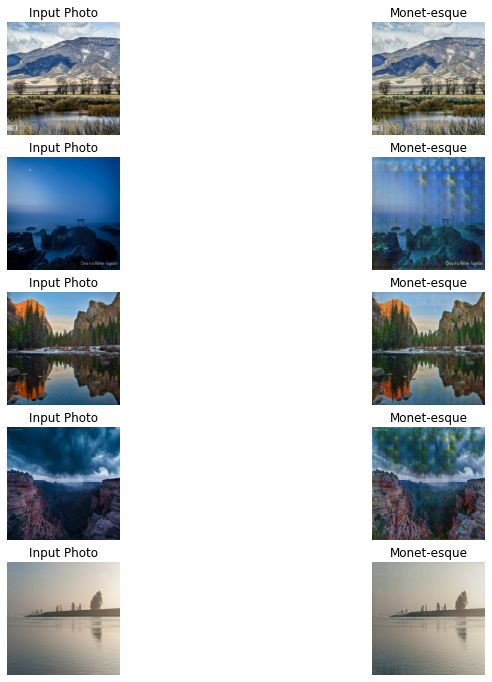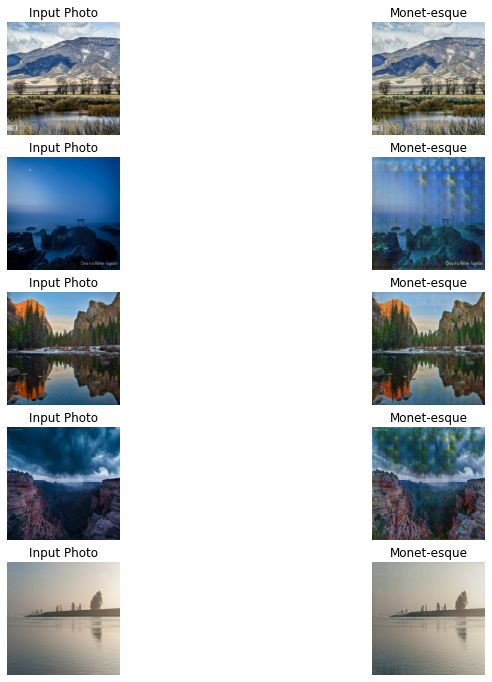

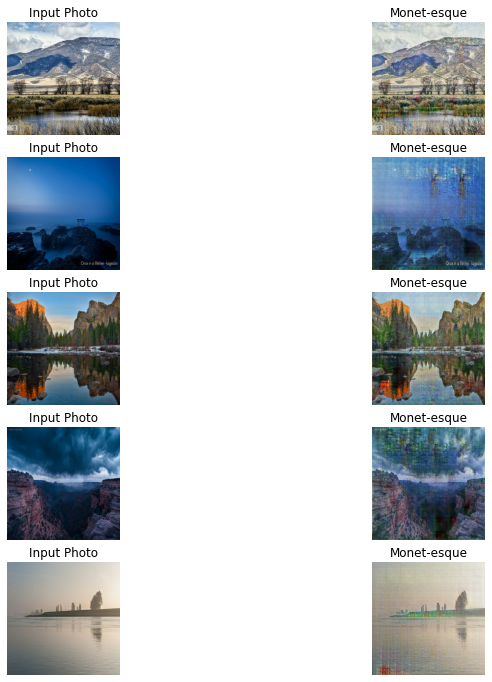

In [26]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

# Create submission file

Finally, the generator model is run for each of the images and the result is saved in a aip file containing the transformed images.
Current score is shown here:

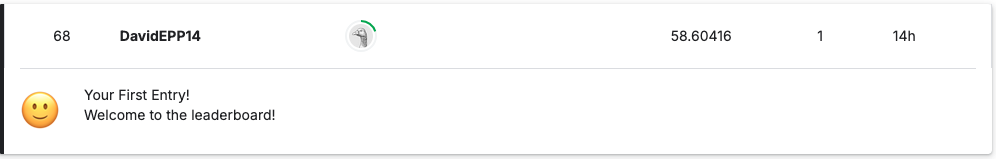
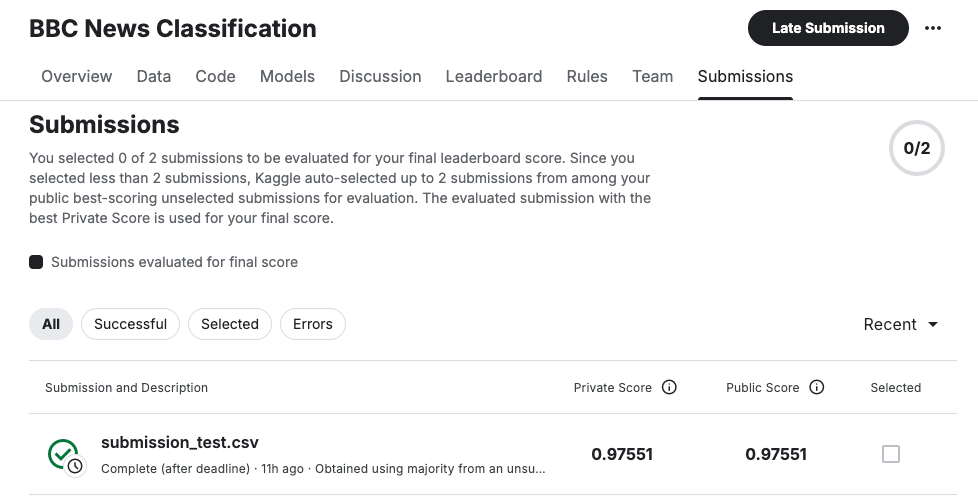

In [27]:
import PIL
! mkdir ../images

In [28]:
i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

In [29]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'

# References
1. https://keras.io/examples/generative/cyclegan/
2. https://www.tensorflow.org/tutorials/generative/cyclegan
3. https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial